In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import feather
num_t = 51
num_x = 11
num_y = 11

In [4]:
os.chdir('C:\\Users\\nicholas.clark\\OneDrive - West Point\\Desktop\\Spatial Research\\HawkesSim\\simdata')

In [16]:
n_classes = 2
n_examples = 50
sim_patterns = [None]*n_classes

In [52]:
process = ["hawkes_chi","lgcp_chi"]
sim_patterns = [None]*n_classes
filename = [None]*n_examples
for i in range(n_classes):
    sim_patterns[i] = [None]*n_examples
    for j in range(n_examples):
        filename[j]= process[i] + "_"+str(j+1)+".feather"
        df = feather.read_dataframe(filename[j])
        df = df.drop(columns = ['t','x'],axis=1)
        sim_patterns[i][j] =df

In [53]:
#df = feather.read_dataframe("hawkes_disc_11.feather")
sim_patterns[1][49].mean().mean()

0.29671437210239876

In [55]:
sim_imgs = np.asarray(sim_patterns)

In [56]:
print(sim_imgs.shape)

(2, 50, 451, 11)


In [57]:
sim_imgs[1][49].mean()

0.2967143721023987

In [58]:

for i in range(n_examples):
    print(sim_imgs[0][i].var()-sim_imgs[1][i].var())


0.07065674648876841
0.08568889342515651
0.11147616597933951
0.13008574317694543
0.08510697083695062
0.12218675960742109
0.10972389719432618
0.07652749295746508
0.11659328165861826
0.13977941468956762
0.11286860328542891
0.08746797891930369
0.14808674360272167
0.17727697528324227
0.18031376443576974
0.08674709702013117
0.06599949673975847
0.12567471957543785
0.11308484347635417
0.11589174029512439
0.12288440035867754
0.13032522451578676
0.12439531876148574
0.11566452963228069
0.09659849954011379
0.07303530732619079
0.1565310815207237
0.10473631434643982
0.18525388983476476
0.11668015154366107
0.10896612200440609
0.10142453203115742
0.12356164415844118
0.042488637740024426
0.14313077196651114
0.15834096559899735
0.1891176900444308
0.16349773750269248
0.10279023389086761
0.14537606188581365
0.12487257492131432
0.06414703097789043
0.11894526957517171
0.13648274724670617
0.017576890107685816
0.16225092305347566
0.04716620317777187
0.18831383887245334
0.15585440656024474
0.1841543234975197


In [59]:
sim_imgs = sim_imgs.reshape(2,50,41,11,11)

In [60]:
#print(test.shape)

print(sim_imgs.shape)

(2, 50, 41, 11, 11)


In [61]:
print(sim_imgs[0,:,:,:,:].shape)

(50, 41, 11, 11)


In [69]:
# Playing with CNN
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
hawkes_dat = sim_imgs[0,:,:,:,:]
lgcp_dat = sim_imgs[1,:,:,:,:]

hawkes_labels = np.array([1 for _ in range(len(hawkes_dat))])
lgcp_labels = np.array([0 for _ in range(len(lgcp_dat))])
x_train = np.concatenate((hawkes_dat[:35], lgcp_dat[:35]), axis=0)
y_train = np.concatenate((hawkes_labels[:35],lgcp_labels[:35]),axis=0)
x_val = np.concatenate((hawkes_dat[35:],lgcp_dat[35:]),axis=0)
y_val = np.concatenate((hawkes_labels[35:],lgcp_labels[35:]),axis=0)

2.12.0


In [70]:
y_train.mean()

0.5

In [71]:
def get_model(width=41, height=11, depth=11):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

#    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#    x = layers.MaxPool3D(pool_size=2)(x)
#    x = layers.BatchNormalization()(x)#

#    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#    x = layers.MaxPool3D(pool_size=2)(x)
#    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=41, height=11, depth=11)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 41, 11, 11, 1)]   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 39, 9, 9, 64)      1792      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 19, 4, 4, 64)     0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 19, 4, 4, 64)     256       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 17, 2, 2, 64)      110656    
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 8, 1, 1, 64)      0     

In [65]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [72]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
)

Epoch 1/100
35/35 - 3s - loss: 0.7028 - acc: 0.4714 - val_loss: 0.6974 - val_acc: 0.5000 - 3s/epoch - 91ms/step
Epoch 2/100
35/35 - 1s - loss: 0.6509 - acc: 0.6429 - val_loss: 0.6968 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 3/100
35/35 - 1s - loss: 0.5933 - acc: 0.7857 - val_loss: 0.6872 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 4/100
35/35 - 1s - loss: 0.5622 - acc: 0.7429 - val_loss: 0.6723 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 5/100
35/35 - 1s - loss: 0.5414 - acc: 0.8000 - val_loss: 0.6664 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 6/100
35/35 - 1s - loss: 0.5302 - acc: 0.7286 - val_loss: 0.6528 - val_acc: 0.5000 - 1s/epoch - 39ms/step
Epoch 7/100
35/35 - 1s - loss: 0.5296 - acc: 0.7714 - val_loss: 0.6500 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 8/100
35/35 - 2s - loss: 0.4867 - acc: 0.8000 - val_loss: 0.6429 - val_acc: 0.5000 - 2s/epoch - 56ms/step
Epoch 9/100
35/35 - 1s - loss: 0.4164 - acc: 0.8000 - val_loss: 0.6071 - val_acc: 0.6333 - 1s/epoch - 38

Epoch 74/100
35/35 - 1s - loss: 0.0516 - acc: 0.9857 - val_loss: 0.2252 - val_acc: 0.9000 - 1s/epoch - 42ms/step
Epoch 75/100
35/35 - 1s - loss: 0.0474 - acc: 1.0000 - val_loss: 0.2275 - val_acc: 0.8333 - 1s/epoch - 42ms/step
Epoch 76/100
35/35 - 1s - loss: 0.0462 - acc: 0.9857 - val_loss: 0.2244 - val_acc: 0.8333 - 1s/epoch - 42ms/step
Epoch 77/100
35/35 - 1s - loss: 0.0705 - acc: 1.0000 - val_loss: 0.2111 - val_acc: 0.9333 - 1s/epoch - 42ms/step
Epoch 78/100
35/35 - 1s - loss: 0.0449 - acc: 1.0000 - val_loss: 0.2051 - val_acc: 0.9667 - 1s/epoch - 43ms/step
Epoch 79/100
35/35 - 1s - loss: 0.0519 - acc: 1.0000 - val_loss: 0.1982 - val_acc: 0.9000 - 1s/epoch - 42ms/step
Epoch 80/100
35/35 - 1s - loss: 0.0536 - acc: 1.0000 - val_loss: 0.2313 - val_acc: 0.8667 - 1s/epoch - 42ms/step
Epoch 81/100
35/35 - 2s - loss: 0.0422 - acc: 0.9857 - val_loss: 0.2208 - val_acc: 0.8667 - 2s/epoch - 45ms/step
Epoch 82/100
35/35 - 2s - loss: 0.0673 - acc: 1.0000 - val_loss: 0.2938 - val_acc: 0.8333 - 2s/e

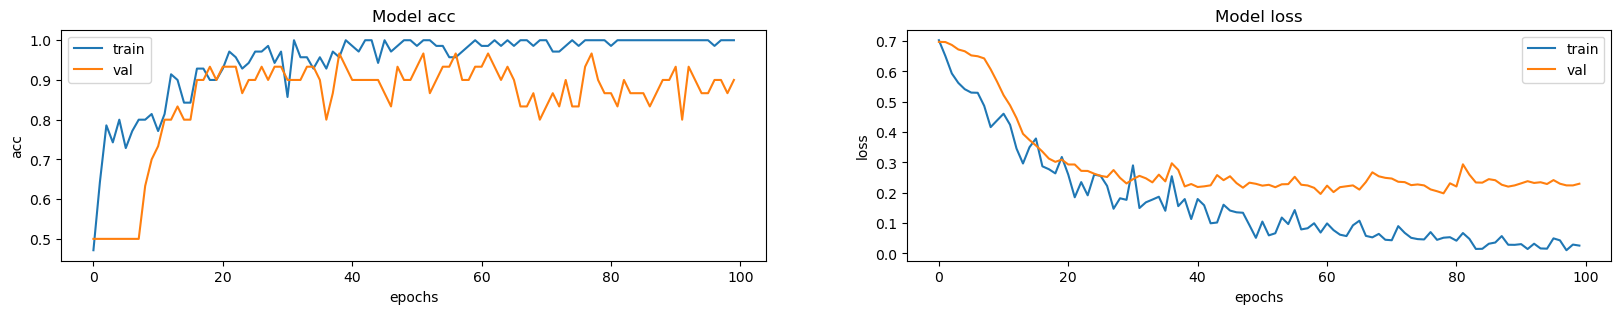

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [135]:
filename_chi= "actual_chi_data.feather"
df_chi = feather.read_dataframe(filename_chi)
df_chi = df_chi.drop(columns = ['t','xvals'],axis=1)
chi_imgs = np.asarray(df_chi)

In [136]:
chi_imgs = chi_imgs.reshape(1,41,11,11,1)

In [142]:
chi_imgs.shape
chi_imgs.var()
df_chi

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,1.0,1.0,0.0
2,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0
4,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
classes = model.predict(chi_imgs)

1/1 [==============================] - 0s 20ms/step


In [139]:
print(classes)

[[0.2059121]]


In [133]:
df_chi

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
test = hawkes_dat[16]

In [125]:
test = test.reshape(1,41,11,11,1)

model.predict(test)


1/1 [==============================] - 0s 21ms/step


array([[0.9998071]], dtype=float32)

In [101]:
sim_vals = [None]*num_t

In [102]:
for count, group in enumerate(test):
    sim_vals[count] = group

In [12]:
X = sim_imgs / sim_imgs.max()
y = []
for i in range(n_classes * n_examples *  num_t*num_x * num_y): 
    y.append(int(i / (n_examples  *  num_t*num_x * num_y)))
y = np.asarray(y)
y = y.reshape([n_classes * n_examples *  num_t*num_x * num_y, 1])
print(y.shape)

(123420, 1)


In [15]:
y = np.asarray(y)
y.mean()

0.5

In [16]:
import numpy.random as rng
n_test = 3


Xtrain = np.zeros([n_classes, n_examples - n_test, num_t, num_x, num_y])
Xval = np.zeros([n_classes, n_test, num_t, num_x, num_y])
print(Xtrain.shape)
print(Xval.shape)

(2, 7, 51, 11, 11)
(2, 3, 51, 11, 11)


In [17]:

ytrain = []
for i in range(n_classes * (n_examples - n_test) *  num_y * num_x * num_t): 
    ytrain.append(int(i / ((n_examples - n_test) * num_y * num_x * num_t)))
ytrain = np.asarray(ytrain)
ytrain = ytrain.reshape([n_classes * (n_examples - n_test) * num_y * num_x * num_t, 1])
yval = []
for i in range(n_classes * n_test *  num_y * num_x * num_t): 
    yval.append(int(i / (n_test * num_y * num_x * num_t)))
yval = np.asarray(yval)
yval = yval.reshape([n_classes * n_test * num_y * num_x * num_t, 1])

print(ytrain.shape)
print(yval.shape)

(86394, 1)
(37026, 1)


0.5

In [18]:
#Come back to this

def get_batch(batch_size, s = "train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = Xtrain
        categories = ytrain
    else:
        X = Xval
        categories = yval
    n_c, n_e, t, h, w = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_c, size=(batch_size,), replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size,t, h, w, 1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size // 2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_e)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(t,h, w, 1)
        idx_2 = rng.randint(0, n_e)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1, n_c)) % n_c
        
        pairs[1][i, :, :, :] = X[category_2, idx_2].reshape(h, w, 1)
    
    return pairs, targets

In [19]:
Xtrain.shape

(2, 7, 51, 11, 11)

In [20]:
rng.choice(n_c, size=(1,), replace=False)

NameError: name 'n_c' is not defined

In [21]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
def make_oneshot_task(N, s="val"):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = ytrain
    else:
        X = Xval
        categories = yval
    n_classes, n_examples, t,h, w = X.shape
    
    categories = rng.choice(range(n_classes), size=(N,), replace=False)            
    indices = rng.randint(0, n_examples, size=(N,))
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1,:,:,:]] * N).reshape(N, h, w, t,1)
    indices[0] = ex2
    support_set = X[categories, indices, :, :,:]
    #support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, h, w, t,1)
    targets = np.zeros((N,))
    targets[0] = 1
   # targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    ## aj
    cat = categories
    ind = [ex1, indices]
    ## aj
    return pairs, targets, cat, ind

  
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k, N))
    for i in range(k):
        inputs, targets, __, __ = make_oneshot_task(N, s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [24]:
iii = rng.randint(0, 6, size=(7,))
jjj = rng.choice(range(n_classes), size=(2,), replace=False) 
eii1, eii2 = rng.choice(6, replace=False, size=(2,))
print(iii)
print(jjj)
print(eii1)
print(eii2)
#
Xtrain[jjj[0], iii, :, :,:].shape
#aaa = np.asarray([Xtrain[jjj[0], eii1,:,:,:]] * 7).reshape(2, num_y, num_x,num_t, 1)
#aaa.shape
#bbb = Xtrain[jjj, iii, :, :,:]

[5 5 0 1 1 4 4]
[1 0]
0
5


(7, 51, 11, 11)

In [43]:
np.asarray([Xtrain[jjj[0], eii1,:,:,:]])

0.0

In [33]:
# one shot task: testing
iii = rng.randint(0, 6, size=(7,))
jjj = rng.choice(range(n_classes), size=(2,), replace=False) 
eii1, eii2 = rng.choice(6, replace=False, size=(2,))
print(iii)
print(jjj)
print(eii1)
print(eii2)
#
Xtrain[jjj[0], iii, :, :,:].shape
aaa = np.asarray([Xtrain[jjj[0], eii1,:,:]] * 7).reshape(7, grid_ny, grid_nx, 1)
aaa.shape
bbb = Xtrain[jjj, iii, :, :,:]
bbb[0, :, :] = Xtrain[jjj[0], eii2, :, :]
bbb = bbb.reshape(7, num_y, num_x, 1)
fig, axs = plt.subplots(7, 2, figsize=(10, 10))
for i in range(7):
  axs[i, 0].imshow(aaa[i, :, :, 0])
  axs[i, 1].imshow(bbb[i, :, :, 0])

[2 1 5 1 5 3 2]
[1 0]
4
5


NameError: name 'grid_ny' is not defined